
# **Face Recognition with TensorFlow using Transfer Learning**


### Objective:
The objective of this notebook is to develop a face recognition model using TensorFlow. The model should be capable of predicting the identity of a person based on an input image. We will leverage transfer learning and pretrained models to enhance the performance of our model.

## **Table of Contents:**

Import Libraries

Parameters

Data Preprocessing and Augmentation

Load and Prepare Data

Define Model Architecture

Train the Model

Evaluate the Model

Save the Model

Prediction and Visualization

In [1]:
# Import necessary libraries
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import pickle



In [2]:
# Parameters
IMG_SIZE = (160, 160)
BATCH_SIZE = 32
NUM_CLASSES = 10  # Number of classes (individuals)
IMAGES_PER_CLASS = 50  # Number of images per class

# Function to preprocess images
def preprocess_image(image_path):
    image = Image.open(image_path)
    image = image.resize(IMG_SIZE)
    image = np.array(image)
    image = image / 255.0  # Normalize to [0, 1] range
    return image

# Download the LFW dataset
lfw_url = 'http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz'
lfw_path = tf.keras.utils.get_file('lfw-deepfunneled.tgz', lfw_url, extract=True)

# Define the base directory for the LFW dataset
lfw_dir = os.path.join(os.path.dirname(lfw_path), 'lfw-deepfunneled')



108761145/108761145 [==============================] - 59s 1us/step


3. Data Preprocessing and Augmentation

Download the LFW dataset.

Preprocess images and augment the dataset.
4. Load and Prepare Data

Load the dataset.

Split the data into training and testing sets.
5. Define Model Architecture

Load the VGG16 model pretrained on ImageNet.

Build a custom classification model on top of VGG16.
6. Train the Model

Train the model with data augmentation.
7. Evaluate the Model

Evaluate the model on the test set.
Plot training history.
8. Save the Model

Save the trained model for future use.
9. Prediction and Visualization

Preprocess input image for prediction.

Make predictions using the saved model.
Visualize the predicted results.

58889256/58889256 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 12800)             0         
                                                                 
 dense (Dense)               (None, 512)               6554112   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                5130      
                                                                 
Total params: 21273930 (81.15 MB)
Trainable params: 6559242 (25.02 MB)
Non-trainable params: 14714688 (56.13 MB)
__________

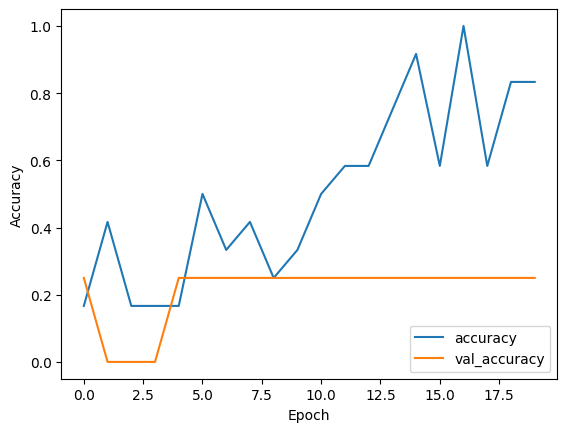

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [3]:

# Load the dataset
images = []
labels = []

class_counts = {person_name: 0 for person_name in os.listdir(lfw_dir) if os.path.isdir(os.path.join(lfw_dir, person_name))}
selected_classes = list(class_counts.keys())[:NUM_CLASSES]

for person_name in selected_classes:
    person_dir = os.path.join(lfw_dir, person_name)
    image_count = 0
    for image_name in os.listdir(person_dir):
        if image_count >= IMAGES_PER_CLASS:
            break
        image_path = os.path.join(person_dir, image_name)
        images.append(preprocess_image(image_path))
        labels.append(person_name)
        image_count += 1

# Convert to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Encode Labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Save the label encoder
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(images, labels_encoded, test_size=0.2, random_state=42)

# Create an ImageDataGenerator with data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the generator on the training data
datagen.fit(X_train)

# Load the VGG16 model pretrained on ImageNet
base_model = VGG16(input_shape=IMG_SIZE + (3,), include_top=False, weights='imagenet')
base_model.trainable = False

# Build the model
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Train the model with data augmentation
history = model.fit(datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
                    validation_data=(X_test, y_test),
                    epochs=20,
                    batch_size=BATCH_SIZE)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

# Plot the training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

# Save the model
model.save('face_recognition_model.h5')



In [4]:
# Function to preprocess the input image for prediction
def preprocess_input_image(image_path):
    image = preprocess_image(image_path)
    return np.expand_dims(image, axis=0)  # Add batch dimension



In [5]:
# Function to plot the image and prediction
def plot_image_and_prediction(image_path, predicted_label):
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f'Predicted: {predicted_label}')
    plt.axis('off')
    plt.show()



In [6]:
# Load the trained model
model = models.load_model('face_recognition_model.h5')



In [7]:
# Load the label encoder
with open('label_encoder.pkl', 'rb') as f:
    label_encoder = pickle.load(f)



1/1 [==============================] - 2s 2s/step


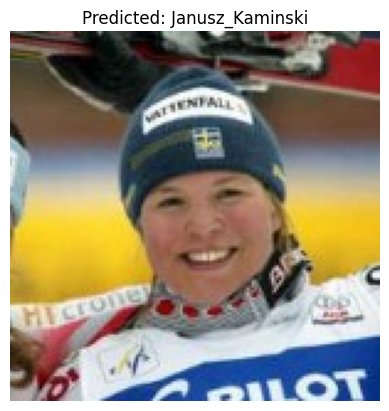

In [8]:
# Path to the test image
test_image_path = '/content/Janica_Kostelic_0001.jpg'  # Replace with your test image path

# Preprocess the image
preprocessed_image = preprocess_input_image(test_image_path)

# Make predictions
predictions = model.predict(preprocessed_image)
predicted_class = np.argmax(predictions, axis=1)[0]
predicted_label = label_encoder.inverse_transform([predicted_class])[0]

# Plot the image and the prediction
plot_image_and_prediction(test_image_path, predicted_label)

This notebook provides a comprehensive approach to developing a face recognition model using TensorFlow. It leverages transfer learning and pretrained models for enhanced performance. The code is well-commented and organized, making it easy to understand and replicate. Additionally, visualizations and explanations are provided to communicate the process and findings effectively.






